In [1]:
from skimage.io import imread
from skimage import morphology, measure
import os, glob, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', size=15)
rc('font', family='Arial')
# rc('font', serif='Times')
rc('pdf', fonttype=42)
# rc('text', usetex=True)


First, define the experiment folder (it depends on whether you are using local machine or server workstation).
So far, the analysis can be run on a single well of a single ibidi slide at a time. In this case we chose 'coated-wt-triton'

In [2]:
pc = os.environ['COMPUTERNAME']
if pc=='PCBA-TRIVEDI03': # my Razer
    folder_raw = os.path.join('E:',os.sep,'immuno_NMG')
elif pc=='PCBA-TRIVEDI02': # workstation
    folder_raw = os.path.join('Y:',os.sep,'Nicola_Gritti','raw_data','immuno_NMG')

exp_folder = os.path.join('2020-12-01_NGM_immuno_tests')

resultFolder = os.path.join(folder_raw, exp_folder, 'results')

down=1
imgName = 'rep2_GFP-stitched_%d%d.tif'%(down,down)

Next, define which channels are available in the images and the color you want to have them displayed with.
In this case, the membrane marker is not present because we remove it at stitching stage...

In [3]:
channels = ['Bright field','DAPI','Trim28']
colors = ['black','blue','green']

Read in the csv file containing the properties of the cells from the StarDist segmentation and skimage-measureprops function (that is, from the previous script).
Also, load the full image and the mask generated by the segmentation

In [4]:
# load cell props
print('Loading cell props...')
props = pd.read_csv(os.path.join(resultFolder,'props_'+os.path.splitext(imgName)[0]+'.csv'))
nch = len([i for i in props.keys() if 'mean_intens' in i])
print('Done. Found %d cells with %d features'%(len(props.label), len(props.keys())))

# load image
print('Loading image...')
X = imread(os.path.join(resultFolder,imgName))
print('Done.',X.shape)

# load image
print('Loading mask...')
maskName = 'mask_'+imgName
Y = imread(os.path.join(resultFolder,maskName))
print('Done.',Y.shape)


Loading cell props...
Done. Found 5596 cells with 23 features
Loading image...
Done. (6320, 6320, 3)
Loading mask...
Done. (6320, 6320)


In [5]:
props.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,eccentricity,mean_intensity-0,mean_intensity-1,mean_intensity-2,min_intensity-0,min_intensity-1,min_intensity-2,max_intensity-0,max_intensity-1,max_intensity-2
0,0,rep2_GFP-stitched_11.tif,1,0,508,37,544,17.700368,526.230699,1088,...,0.387376,16400.633272,1208.409926,432.617647,8689,612,354,22371,1794,650
1,1,rep2_GFP-stitched_11.tif,2,0,562,29,607,12.408829,582.083493,1042,...,0.775055,17494.830134,919.738964,105.819578,14039,460,91,21278,1441,123
2,2,rep2_GFP-stitched_11.tif,3,0,731,28,774,12.378917,751.820513,1053,...,0.763368,17040.554606,1121.418803,291.298196,12518,504,233,20818,1708,366
3,3,rep2_GFP-stitched_11.tif,4,0,1194,47,1245,22.863514,1218.918323,1861,...,0.403228,17704.435787,1046.033315,113.008060,13032,471,91,21513,1547,196
4,4,rep2_GFP-stitched_11.tif,5,0,1316,45,1361,21.673031,1337.186158,1676,...,0.415176,17858.641408,1025.927208,108.529833,13768,473,91,21259,1562,136


In [6]:
print(props.keys())
print('Cells:', len(props.label))

Index(['Unnamed: 0', 'fileName', 'label', 'bbox-0', 'bbox-1', 'bbox-2',
       'bbox-3', 'centroid-0', 'centroid-1', 'area', 'perimeter',
       'minor_axis_length', 'major_axis_length', 'eccentricity',
       'mean_intensity-0', 'mean_intensity-1', 'mean_intensity-2',
       'min_intensity-0', 'min_intensity-1', 'min_intensity-2',
       'max_intensity-0', 'max_intensity-1', 'max_intensity-2'],
      dtype='object')
Cells: 5596


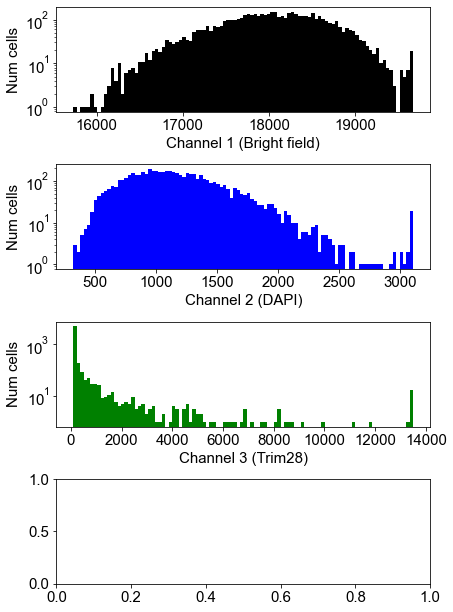

In [7]:
# plot of distributions
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(6,9))
fig.subplots_adjust(top=0.99, hspace=0.5, bottom=0.1, right=0.99)
for i in range(nch):
    data = props['mean_intensity-%d'%i]
    data = np.clip(data,0,np.percentile(data, 99.7))
    ax[i].hist(data, bins=100, color=colors[i])
    ax[i].set_xlabel('Channel %d (%s)'%(i+1,channels[i]))
    ax[i].set_ylabel('Num cells')
    ax[i].set_yscale('log')
plt.show()

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_histogram.png'),dpi=300)

Transfected cells: 321
Not transfected cells: 5275


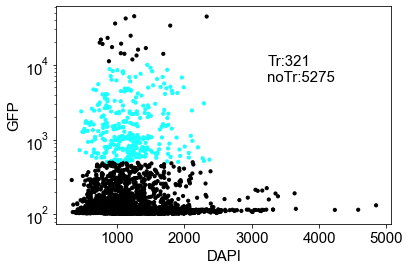

In [8]:
# determine cutoff to define cells that were successfully transfected
# use the gfp channel to determine threshold.
gfp = props['mean_intensity-%d'%2].values
dapi = props['mean_intensity-%d'%1].values

# Assume bimodal distribution (negative cells + positive cells) and use KMeans clustering with 2 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

# cluster the data points
kmeans.fit(gfp.reshape(-1,1))
y_kmeans = kmeans.predict(gfp.reshape(-1,1))

# custom threshold
y_kmeans = (gfp>500)&(gfp<10000)

# visualize
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.0, 0.0, 0.0), (0,0,.5), (.2, .2, 1.), (.1,1.,1.)] # Experiment with this
cm = LinearSegmentedColormap.from_list('test', colors, N=255)

fig, ax = plt.subplots()
ax.scatter(dapi, gfp, c=y_kmeans, s=10, cmap=cm)
plt.yscale('log')
ax.set_xlabel('DAPI')
ax.set_ylabel('GFP')

# assign cluster to cells
props['transfected'] = y_kmeans.astype(bool)
ax.text(np.max(props['mean_intensity-1'])*2/3,10000,'Tr:'+str(len(props[props.transfected])))
ax.text(np.max(props['mean_intensity-1'])*2/3,6000,'noTr:'+str(len(props[props.transfected==False])))

print('Transfected cells:', len(props[props.transfected]))
print('Not transfected cells:', len(props[props.transfected==False]))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_transfected.png'),dpi=300)

In [9]:
transfected = props[props.transfected]
transfected.head()

,Unnamed: 0,fileName,label,bbox-0,bbox-1,bbox-2,bbox-3,centroid-0,centroid-1,area,...,mean_intensity-0,mean_intensity-1,mean_intensity-2,min_intensity-0,min_intensity-1,min_intensity-2,max_intensity-0,max_intensity-1,max_intensity-2,transfected
16,16,rep2_GFP-stitched_11.tif,17,0,5503,36,5552,16.217087,5526.895658,1428,...,18014.918067,797.066527,2068.226190,12368,343,1279,21242,1230,2902,True
169,169,rep2_GFP-stitched_11.tif,170,153,6242,199,6294,174.934873,6268.293073,1689,...,17724.801658,536.579633,672.082297,11664,296,321,23565,704,1016,True
199,199,rep2_GFP-stitched_11.tif,200,195,5386,241,5427,216.739130,5405.566576,1472,...,18363.606658,654.317935,739.332880,10899,340,386,24328,948,1035,True
236,236,rep2_GFP-stitched_11.tif,237,238,5402,283,5439,259.661388,5420.304676,1326,...,18706.136501,717.656109,653.232278,13686,372,420,24753,1116,935,True
244,244,rep2_GFP-stitched_11.tif,245,248,5882,297,5927,272.264982,5903.704465,1702,...,18560.593420,538.618096,1767.729142,12636,318,960,24545,748,2529,True


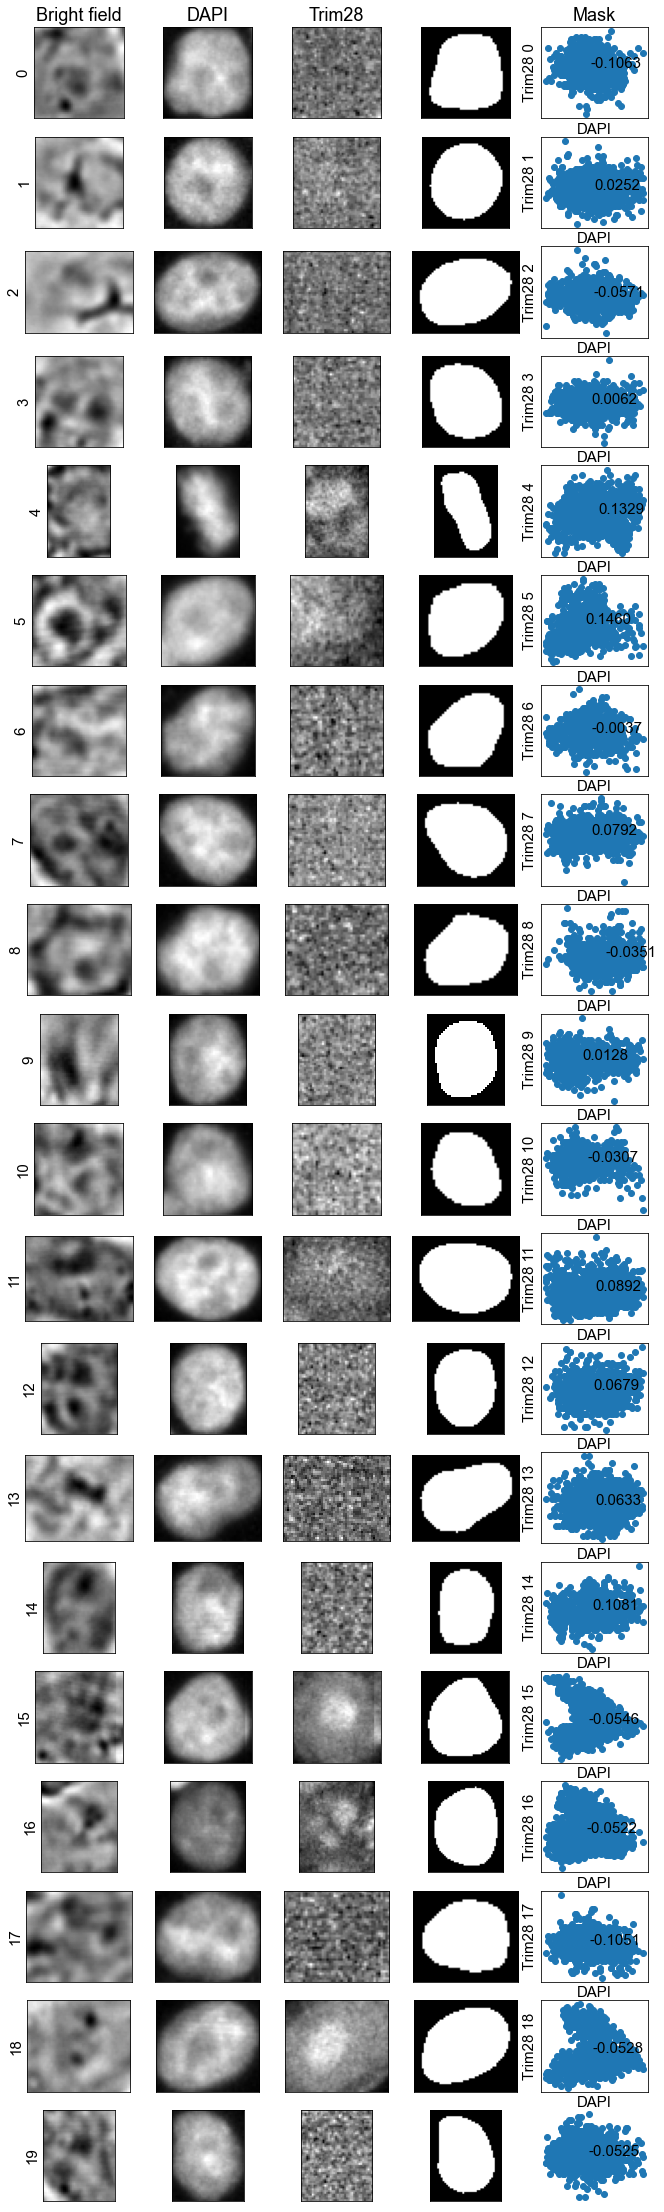

In [10]:
n_sample = 20
not_transfected_sample = props[[not i for i in props.transfected.values]].sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,len(channels)+2,figsize=(10,2*n_sample))
plt.subplots_adjust(hspace=0.2,right=0.99)

i=0
for idx, cell in not_transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[j], cmap='gray')#,clim=(0,5000))
    ax[i,-2].imshow(cell_mask, cmap='gray')
    ax[i,0].set_ylabel(i)

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    ax[i,-1].scatter(dapi,trim28)
    ax[i,-1].set_xlabel('DAPI')
    ax[i,-1].set_ylabel('Trim28 %d'%i)
    ax[i,-1].text(0,0,'%.04f'%np.corrcoef(dapi,trim28)[0,1])
    
    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
    plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

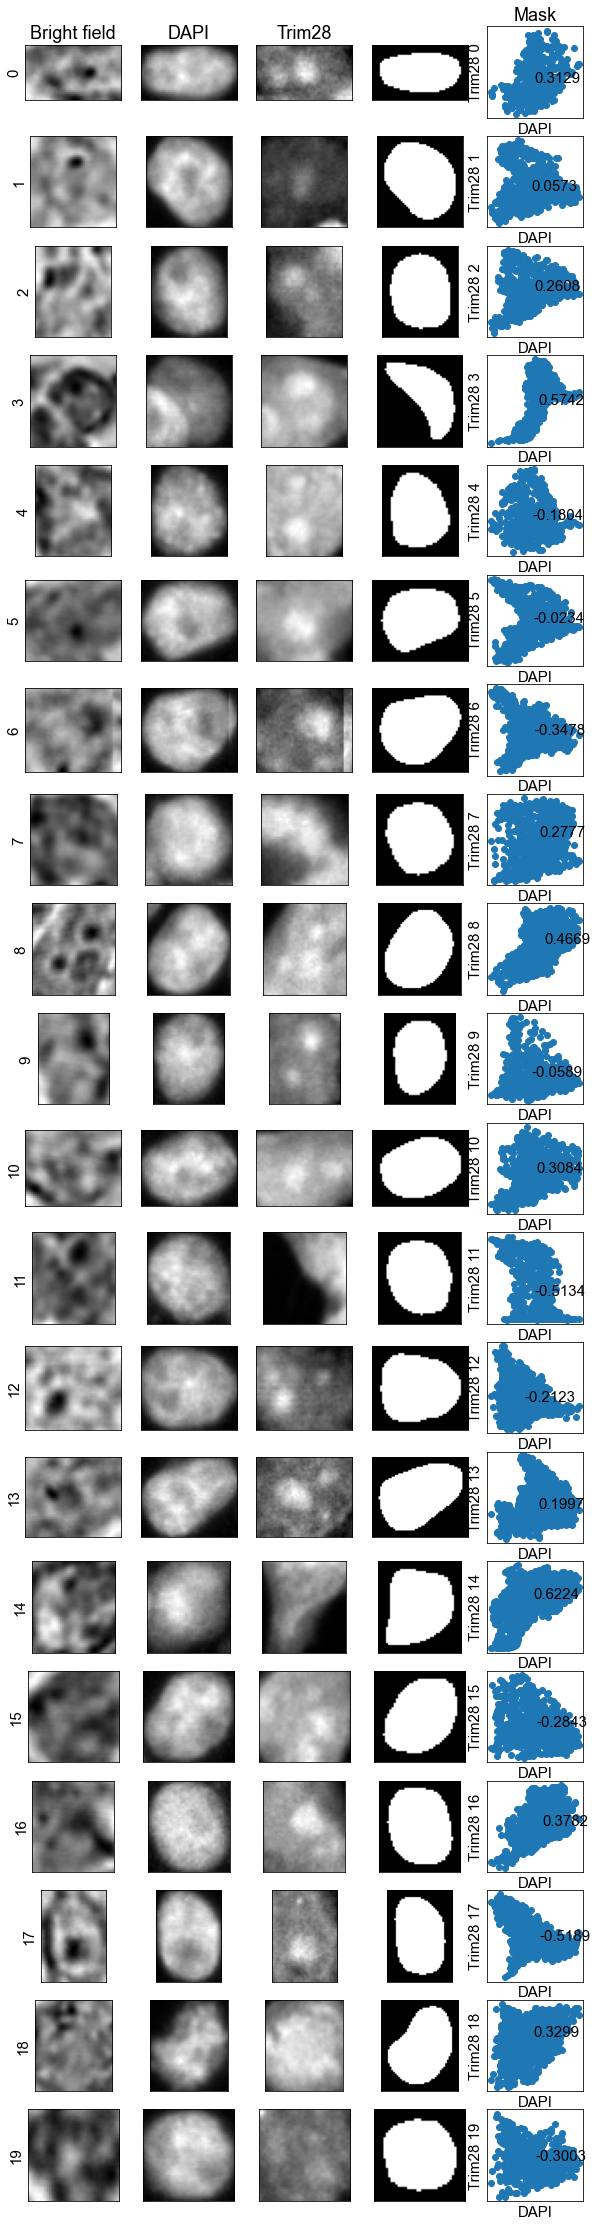

In [11]:
n_sample = 20
transfected_sample = transfected.sample(n=n_sample) 

fig,ax=plt.subplots(n_sample,len(channels)+2,figsize=(10,2*n_sample))

i=0
for idx, cell in transfected_sample.iterrows():
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    for j in range(len(channels)):
        ax[i,j].imshow(cell_img[j], cmap='gray')#,clim=(0,5000))
    ax[i,-2].imshow(cell_mask, cmap='gray')
    ax[i,0].set_ylabel(i)

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    ax[i,-1].scatter(dapi,trim28)
    ax[i,-1].set_xlabel('DAPI')
    ax[i,-1].set_ylabel('Trim28 %d'%i)
    ax[i,-1].text(0,0,'%.04f'%np.corrcoef(dapi,trim28)[0,1])
    
    i+=1

for j in range(len(channels)):
    ax[0,j].set_title(channels[j])
#     plt.axis('off')
ax[0,-1].set_title('Mask')

# remove the x and y ticks
for i, a in enumerate(ax.flatten()):
    a.set_xticks([])
    a.set_yticks([])

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_exampleImages.png'),dpi=300)

In [12]:
corr_12 = [np.nan for i in range(len(props))] # dapi-trim28

i=0
for idx, cell in tqdm.tqdm(props.iterrows(), total=len(props.label)):
    cell_img = X[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3']),:]
    cell_img = np.moveaxis(cell_img, -1, 0)
    
    cell_mask = Y[int(cell['bbox-0']):int(cell['bbox-2']),int(cell['bbox-1']):int(cell['bbox-3'])]
    cell_mask = np.pad(cell_mask,1)
    cell_mask = morphology.binary_erosion(cell_mask==cell.label,morphology.disk(4))
    cell_mask = cell_mask[1:-1,1:-1]

    dapi = cell_img[1].flatten()
    dapi = dapi[cell_mask.flatten()==True]
    dapi = (dapi-np.mean(dapi))/np.mean(dapi)
    
    trim28 = cell_img[2].flatten()
    trim28 = trim28[cell_mask.flatten()==True]
    trim28 = (trim28-np.mean(trim28))/np.mean(trim28)
    
    corr_12[i] = np.corrcoef(dapi,trim28)[0,1]
#     corr_12[i] = cov(dapi,trim28,w)
        
    i+=1

# append data to dataframe
props['corr_12'] = corr_12
    

100%|████████████████████████████████████████████████████████████████████████████| 5596/5596 [00:04<00:00, 1131.44it/s]


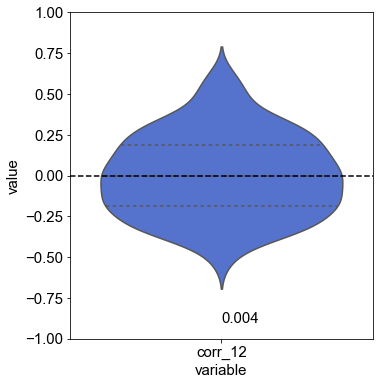

DAPI-Trim28: 0.004385080450832801 0.2532138911189138


In [13]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected]
df = df[['corr_12']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue'], inner='quartile')#, showfliers=False)

# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=1, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrTransfected.png'),dpi=300)

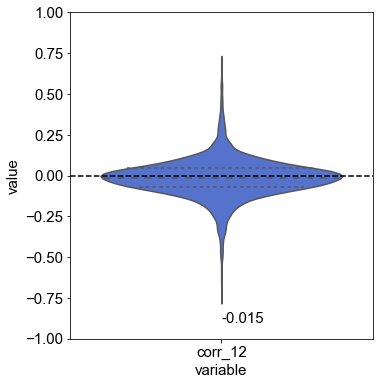

DAPI-Trim28: -0.014625163645667023 0.12031767775581396


In [14]:
# for the sample, show correlation plots
import seaborn as sns
df = props[props.transfected==False]
df = df[['corr_12']]

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

sns.violinplot(x="variable", y="value", data=pd.melt(df), ax=ax, palette=['royalblue'], inner='quartile')#, showfliers=False)
# sns.boxplot(x="variable", y="value", data=pd.melt(df), ax=ax, showfliers=False, palette=['royalblue','limegreen','indianred'])
# sns.swarmplot(x="variable", y="value", data=pd.melt(df), ax=ax, s=2, color='black')

ax.set_ylim(-1,1)
ax.plot([-0.5,2.5],[0,0],'--k')
ax.set_xlim(-0.5,0.5)

ax.text(0,-0.9,'%.3f'%np.mean(df['corr_12']))
plt.show()

print('DAPI-Trim28:', np.mean(df['corr_12']), np.std(df['corr_12']))

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrNotTransfected.png'),dpi=300)

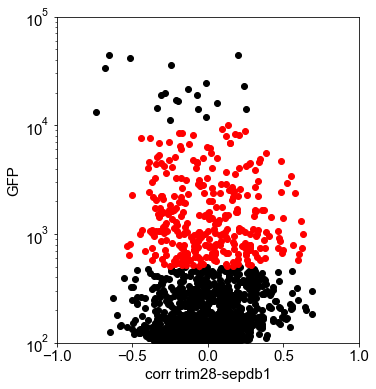

In [15]:

fig,ax=plt.subplots(figsize=(6,6))
fig.subplots_adjust(left=0.2,hspace=0.5,wspace=0.3)

not_trasnfected = props[props.transfected==False]
ax.scatter(not_trasnfected['corr_12'],not_trasnfected['mean_intensity-2'],color='black')
transfected = props[props.transfected==True]
ax.scatter(transfected['corr_12'],transfected['mean_intensity-2'],color='red')
ax.set_xlabel('corr trim28-sepdb1')
ax.set_ylabel('GFP')
ax.set_yscale('log')
ax.set_xlim(-1,1)
ax.set_ylim(1e2, 1e5)

fig.savefig(os.path.join(resultFolder, os.path.splitext(imgName)[0].split('-')[0] + '_corrVsGFP.png'),dpi=300)